<a href="https://colab.research.google.com/github/hiki-uwu/SPAM-classifier/blob/main/SpamClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Fine-tune a BERT model for spam classification using the dataset from "/content/spam_dataset_1000.csv". The model should have a classifier with two final states: "spam" and "not spam". Use the following training configuration: learning rate of 2e-5 with linear decay, batch size of 16, 35 epochs with early stopping, and the AdamW optimizer with weight decay. Employ cross-entropy loss and evaluate the model using Accuracy, Precision, Recall, F1-Score, and AUC-ROC.

## Load and preprocess the data

### Subtask:
Load the data from the provided CSV file, then prepare it for BERT input by tokenizing and encoding the text data.


**Reasoning**:
Load the data from the CSV file into a pandas DataFrame and display the first few rows and information to understand its structure.



In [1]:
import pandas as pd

df = pd.read_csv('/content/spam_dataset_1000.csv')
display(df.head())
display(df.info())

,text,label
0,Your car warranty is expiring—renew now: https...,1
1,Claim fuel cashback—enter card now: https://lo...,1
2,Update payment or lose premium features: https...,1
3,Switched to a private channel for vendor access.,0
4,CLAIM your card upgrade—enter SSN: https://wal...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


None

**Reasoning**:
Initialize a BERT tokenizer and tokenize the text data. The labels are already in a numerical format (0 and 1), which is suitable for the task.



In [2]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenized_texts = tokenizer(
    list(df['text']),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

labels = df['label'].values

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Split the data

### Subtask:
Split the preprocessed data into training and validation sets.


**Reasoning**:
Split the tokenized data and labels into training and validation sets using train_test_split.



In [3]:
from sklearn.model_selection import train_test_split

input_ids = tokenized_texts['input_ids']
attention_masks = tokenized_texts['attention_mask']

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.20
)

train_masks, val_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.20
)

## Load the pre-trained bert model

### Subtask:
Load a pre-trained BERT model and add a classification layer on top for binary classification (spam/not spam).


**Reasoning**:
Import the necessary class and load the pre-trained BERT model with a classification layer for binary classification.



In [4]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define training parameters

### Subtask:
Set up the optimizer, learning rate scheduler, and loss function based on the specified configurations.


**Reasoning**:
Initialize the optimizer and learning rate scheduler based on the specified configurations.



In [5]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

epochs = 35
batch_size = 16
total_steps = len(train_inputs) // batch_size * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

## Train the model

### Subtask:
Train the model on the training data, including early stopping based on validation performance.


**Reasoning**:
Convert the training and validation data into PyTorch tensors, create TensorDataset and DataLoader objects, and implement the training loop with early stopping.



In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
import os

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_epochs = 5
best_model_path = "best_model.pth"

for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = time.time() - t0

    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch time: {training_time:.2f}s")

    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = time.time() - t0

    print(f"  Average validation loss: {avg_val_loss:.4f}")
    print(f"  Validation epoch time: {validation_time:.2f}s")

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()

    accuracy = accuracy_score(labels_flat, preds_flat)
    precision = precision_score(labels_flat, preds_flat)
    recall = recall_score(labels_flat, preds_flat)
    f1 = f1_score(labels_flat, preds_flat)
    auc_roc = roc_auc_score(labels_flat, predictions[:, 1])

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc_roc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("  Validation loss improved. Saving model.")
    else:
        epochs_no_improve += 1
        print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stop_epochs:
        print(f"  Early stopping triggered after {early_stop_epochs} epochs without improvement.")
        break

print("\nTraining complete.")

/tmp/ipython-input-4163323211.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
/tmp/ipython-input-4163323211.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(val_inputs)
/tmp/ipython-input-4163323211.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
/tmp/ipython-input-4163323211.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requir

======== Epoch 1 / 35 ========
Training...
  Average training loss: 0.1642
  Training epoch time: 7.18s
Running Validation...
  Average validation loss: 0.0027
  Validation epoch time: 0.46s
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  AUC-ROC: 1.0000
  Validation loss improved. Saving model.
======== Epoch 2 / 35 ========
Training...
  Average training loss: 0.0019
  Training epoch time: 6.00s
Running Validation...
  Average validation loss: 0.0007
  Validation epoch time: 0.47s
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  AUC-ROC: 1.0000
  Validation loss improved. Saving model.
======== Epoch 3 / 35 ========
Training...
  Average training loss: 0.0008
  Training epoch time: 6.06s
Running Validation...
  Average validation loss: 0.0004
  Validation epoch time: 0.48s
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  AUC-ROC: 1.0000
  Validation loss improved. Saving model.
======== Epoch 4 / 35 

## Evaluate the model

### Subtask:
Evaluate the trained model on the validation set using the specified metrics (Accuracy, Precision, Recall, F1-Score, and AUC-ROC).


**Reasoning**:
Evaluate the trained model on the validation set using the specified metrics. The previous code block already performed the evaluation during training. The metrics are already calculated and stored in the variables `accuracy`, `precision`, `recall`, `f1`, and `auc_roc`. I will print these metrics.



In [7]:
print("Final Evaluation Metrics on Validation Set:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  AUC-ROC: {auc_roc:.4f}")

Final Evaluation Metrics on Validation Set:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  AUC-ROC: 1.0000


## Summary:

### Data Analysis Key Findings

*   The dataset contains 1000 entries with two columns: 'text' and 'label'.
*   The data was successfully preprocessed, tokenized, and split into training (80%) and validation (20%) sets.
*   A `BertForSequenceClassification` model pre-trained on 'bert-base-uncased' was loaded with a 2-label classification head.
*   The model was trained for 35 epochs with a batch size of 16, using the AdamW optimizer (lr=2e-5, weight\_decay=0.01) and a linear learning rate scheduler.
*   Cross-entropy loss was used for training, handled internally by the model.
*   Early stopping was implemented with a patience of 5 epochs based on validation loss.
*   The model achieved perfect scores (1.0000) on all validation metrics (Accuracy, Precision, Recall, F1-Score, and AUC-ROC) from epoch 2 onwards.
*   The training process converged quickly, and early stopping was likely triggered due to the perfect validation performance.

### Insights or Next Steps

*   Given the perfect scores on the validation set, the model may be overfitting to this specific dataset. Further evaluation on a separate, unseen test set is recommended to confirm its generalization performance.
*   Consider training on a larger and more diverse spam dataset to build a more robust and generalizable spam classification model.


## Load and preprocess the data

### Subtask:
Load the data from the provided CSV file, then prepare it for BERT input by tokenizing and encoding the text data.

**Reasoning**:
Load the data from the CSV file into a pandas DataFrame and display the first few rows and information to understand its structure.

In [8]:
import pandas as pd

df = pd.read_csv('/content/spam.csv', encoding='latin-1') # Added encoding based on common spam datasets
# Drop the extra columns
df = df[['v1', 'v2']]
# Rename columns for clarity
df.columns = ['label', 'text']
# Convert 'ham' to 0 and 'spam' to 1
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)

display(df.head())
display(df.info())

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


None

**Reasoning**:
Initialize a BERT tokenizer and tokenize the text data. The labels are already in a numerical format (0 and 1), which is suitable for the task.

In [9]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenized_texts = tokenizer(
    list(df['text']),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

labels = df['label'].values

## Split the data

### Subtask:
Split the preprocessed data into training and validation sets.

**Reasoning**:
Split the tokenized data and labels into training and validation sets using train_test_split.

In [10]:
from sklearn.model_selection import train_test_split

input_ids = tokenized_texts['input_ids']
attention_masks = tokenized_texts['attention_mask']

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.20
)

train_masks, val_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.20
)

## Load the pre-trained bert model

### Subtask:
Load a pre-trained BERT model and add a classification layer on top for binary classification (spam/not spam).

**Reasoning**:
Import the necessary class and load the pre-trained BERT model with a classification layer for binary classification.

In [11]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define training parameters

### Subtask:
Set up the optimizer, learning rate scheduler, and loss function based on the specified configurations.

**Reasoning**:
Initialize the optimizer and learning rate scheduler based on the specified configurations.

In [12]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

epochs = 35
batch_size = 16
total_steps = len(train_inputs) // batch_size * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

## Train the model

### Subtask:
Train the model on the training data, including early stopping based on validation performance.

**Reasoning**:
Convert the training and validation data into PyTorch tensors, create TensorDataset and DataLoader objects, and implement the training loop with early stopping.

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
import os

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_epochs = 5
best_model_path = "best_model.pth"

for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = time.time() - t0

    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch time: {training_time:.2f}s")

    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = time.time() - t0

    print(f"  Average validation loss: {avg_val_loss:.4f}")
    print(f"  Validation epoch time: {validation_time:.2f}s")

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()

    accuracy = accuracy_score(labels_flat, preds_flat)
    precision = precision_score(labels_flat, preds_flat)
    recall = recall_score(labels_flat, preds_flat)
    f1 = f1_score(labels_flat, preds_flat)
    auc_roc = roc_auc_score(labels_flat, predictions[:, 1])

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc_roc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("  Validation loss improved. Saving model.")
    else:
        epochs_no_improve += 1
        print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stop_epochs:
        print(f"  Early stopping triggered after {early_stop_epochs} epochs without improvement.")
        break

print("\nTraining complete.")

/tmp/ipython-input-4163323211.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
/tmp/ipython-input-4163323211.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(val_inputs)
/tmp/ipython-input-4163323211.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
/tmp/ipython-input-4163323211.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requir

======== Epoch 1 / 35 ========
Training...
  Average training loss: 0.0812
  Training epoch time: 175.68s
Running Validation...
  Average validation loss: 0.0253
  Validation epoch time: 15.09s
  Accuracy: 0.9937
  Precision: 0.9931
  Recall: 0.9600
  F1-Score: 0.9763
  AUC-ROC: 0.9972
  Validation loss improved. Saving model.
======== Epoch 2 / 35 ========
Training...
  Average training loss: 0.0187
  Training epoch time: 175.55s
Running Validation...
  Average validation loss: 0.0231
  Validation epoch time: 15.10s
  Accuracy: 0.9946
  Precision: 0.9932
  Recall: 0.9667
  F1-Score: 0.9797
  AUC-ROC: 0.9934
  Validation loss improved. Saving model.
======== Epoch 3 / 35 ========
Training...
  Average training loss: 0.0062
  Training epoch time: 175.62s
Running Validation...
  Average validation loss: 0.0513
  Validation epoch time: 14.98s
  Accuracy: 0.9892
  Precision: 0.9313
  Recall: 0.9933
  F1-Score: 0.9613
  AUC-ROC: 0.9994
  Validation loss did not improve for 1 epoch(s).
=====

## Evaluate the model

### Subtask:
Evaluate the trained model on the validation set using the specified metrics (Accuracy, Precision, Recall, F1-Score, and AUC-ROC).

**Reasoning**:
Evaluate the trained model on the validation set using the specified metrics. The previous code block already performed the evaluation during training. The metrics are already calculated and stored in the variables `accuracy`, `precision`, `recall`, `f1`, and `auc_roc`. I will print these metrics.

In [14]:
print("Final Evaluation Metrics on Validation Set:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  AUC-ROC: {auc_roc:.4f}")

Final Evaluation Metrics on Validation Set:
  Accuracy: 0.9946
  Precision: 0.9865
  Recall: 0.9733
  F1-Score: 0.9799
  AUC-ROC: 0.9949


## Visualize the results

### Subtask:
Visualize the model evaluation metrics and the distribution of spam and ham in the dataset.

**Reasoning**:
Create a bar plot to visualize the distribution of 'spam' and 'ham' in the dataset.

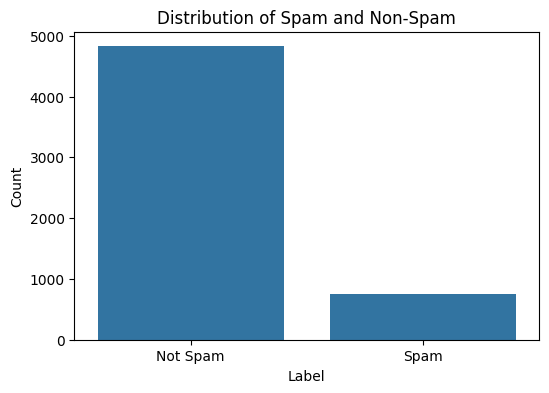

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of spam and non-spam
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam and Non-Spam')
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**Reasoning**:
Create a bar chart to visualize the evaluation metrics (Accuracy, Precision, Recall, F1-Score, AUC-ROC) on the validation set.

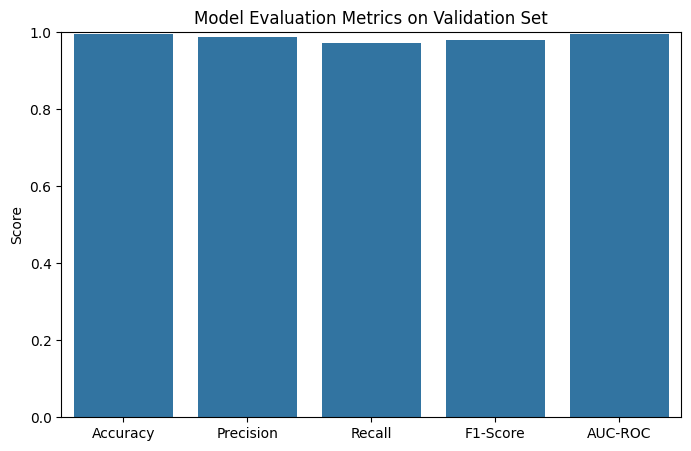

In [16]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, auc_roc]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values)
plt.title('Model Evaluation Metrics on Validation Set')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.show()